## Ingeniería de variables

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [51]:
def plot_percent_cols(df, li=25, lm=50, ls=75):
    # Calcular los porcentajes de datos nulos y no nulos
    null_percent = df.isnull().mean() * 100
    not_null_percent = 100 - null_percent

    # Crear la figura y el eje con un tamaño específico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear el gráfico de barras acumulado
    ax.bar(df.columns, not_null_percent, label='Not Null')
    ax.bar(df.columns, null_percent, bottom=not_null_percent, label='Null')

    # Agregar las líneas horizontales
    ax.axhline(li, color='r', linestyle='--')
    ax.axhline(lm, color='g', linestyle='--')
    ax.axhline(ls, color='b', linestyle='--')

    # Agregar la leyenda
    ax.legend()

    # Agregar títulos
    plt.title('Porcentaje de datos nulos y no nulos por columna')

    # Mostrar el gráfico
    plt.xticks(rotation=90)
    plt.show()

### 1. Leer los datos

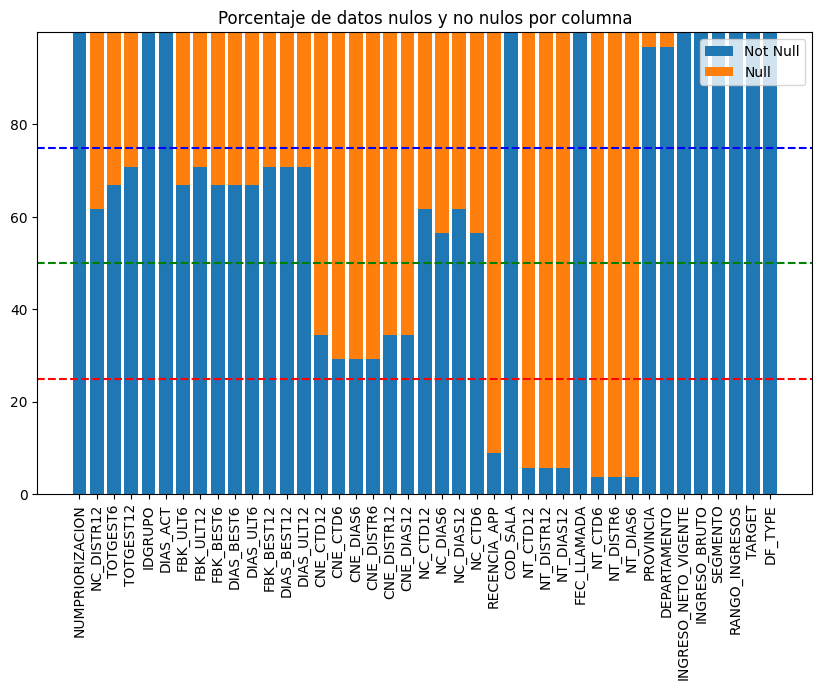

In [52]:
df = pd.read_parquet('./data/1_data_exploracion_datos.parquet')
plot_percent_cols(df)

### 2. Limpieza general de datos

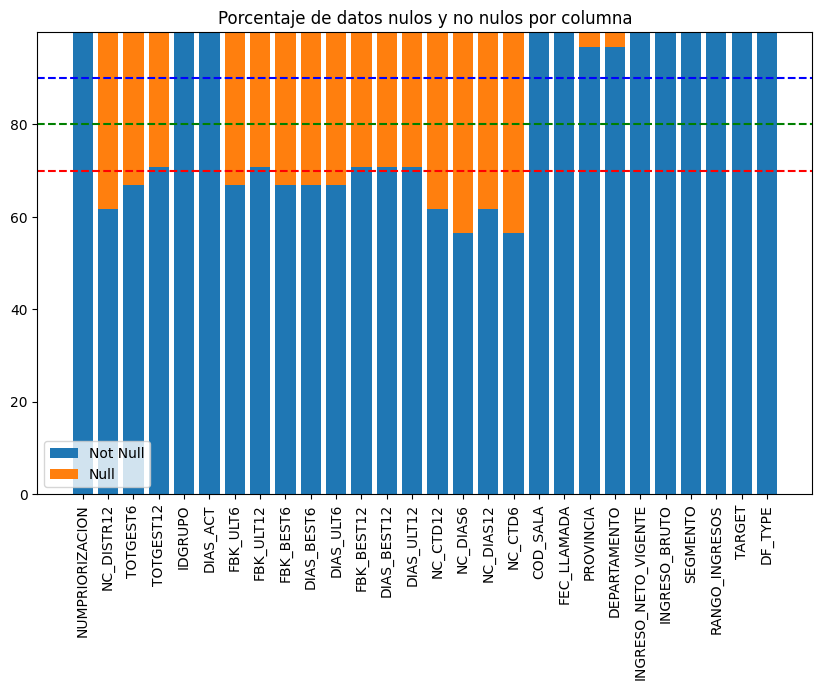

In [53]:
# Eliminar las columnas con más del 50% de datos nulos
df = df.dropna(thresh=df.shape[0]*0.5, axis=1)
plot_percent_cols(df, li=70, lm=80, ls=90)

### 3. Limpieza y tratamiento de datos categóricos

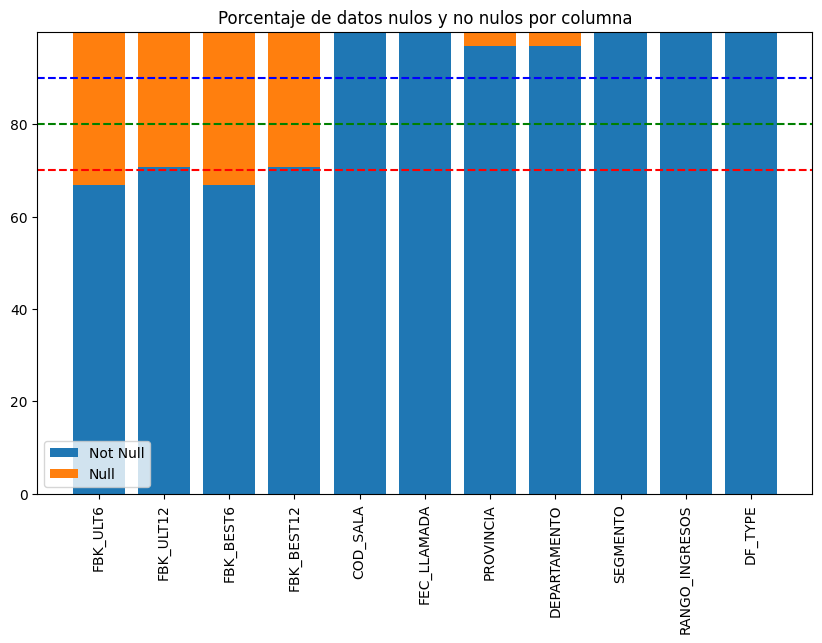

In [54]:
# Seleccionar las columnas con datos categoricos
df_cat = df.select_dtypes(include=['object'])
plot_percent_cols(df_cat, li=70, lm=80, ls=90)

In [55]:
# Eliminar la columna PROVINCIA, FEC_LLAMADA y DF_TYPE
df_cat = df_cat.drop(columns=['PROVINCIA', 'FEC_LLAMADA', 'DF_TYPE'])
print('Eliminando columnas PROVINCIA, FEC_LLAMADA y DF_TYPE')

Eliminando columnas PROVINCIA, FEC_LLAMADA y DF_TYPE


In [56]:
# Reducir a 2 categorias la columna DEPARTAMENTO
df_cat['DEPARTAMENTO'] = df_cat['DEPARTAMENTO'].apply(lambda x: 'FUERA DE LIMA' if x != 'LIMA' else x)
print(df_cat['DEPARTAMENTO'].value_counts(dropna=False, normalize=True))

DEPARTAMENTO
LIMA             0.591556
FUERA DE LIMA    0.408444
Name: proportion, dtype: float64


In [57]:
# Crear categoría "SIN DATOS" para FBK_ULT6, FBK_ULT12, FBK_BEST6, FBK_BEST12
df_cat['FBK_ULT6'] = df_cat['FBK_ULT6'].fillna('SIN DATOS')
df_cat['FBK_ULT12'] = df_cat['FBK_ULT12'].fillna('SIN DATOS')
df_cat['FBK_BEST6'] = df_cat['FBK_BEST6'].fillna('SIN DATOS')
df_cat['FBK_BEST12'] = df_cat['FBK_BEST12'].fillna('SIN DATOS')

In [58]:
# Imputar moda para la columna COD_SALA con datos nulos
df_cat['COD_SALA'] = df_cat['COD_SALA'].fillna(df_cat['COD_SALA'].mode()[0])
print(df_cat['COD_SALA'].value_counts(dropna=False, normalize=True))

COD_SALA
NC     0.305764
EC     0.165888
C      0.110371
PP     0.110255
CD     0.089365
PA     0.060782
CON    0.042606
IL     0.037769
UPG    0.027446
PRR    0.023040
2DA    0.020500
DIL    0.003780
BPE    0.002407
DEF    0.000024
TC     0.000004
Name: proportion, dtype: float64


In [59]:
# Imputar moda para la columna SEGMENTO con datos nulos
df_cat['SEGMENTO'] = df_cat['SEGMENTO'].fillna(df_cat['SEGMENTO'].mode()[0])
print(df_cat['SEGMENTO'].value_counts(dropna=False, normalize=True))

SEGMENTO
3      0.413921
2      0.262877
1BC    0.147100
1A     0.101020
4      0.063017
5      0.009307
6      0.002759
Name: proportion, dtype: float64


In [60]:
# Imputar moda para la columna RANGO_INGRESOS con datos nulos
df_cat['RANGO_INGRESOS'] = df_cat['RANGO_INGRESOS'].fillna(df_cat['RANGO_INGRESOS'].mode()[0])
print(df_cat['RANGO_INGRESOS'].value_counts(dropna=False, normalize=True))

RANGO_INGRESOS
Entre S/.1000-4000     0.555416
Entre S/.4000-10000    0.352411
Mayor a S/.10000       0.081359
Entre S/.600-1000      0.007701
Sin ingresos           0.002983
Entre S/.0-600         0.000129
Name: proportion, dtype: float64


In [61]:
# Eliminar FBK_ULT6, FBK_BEST6
df_cat = df_cat.drop(columns=['FBK_ULT6', 'FBK_BEST6'])
print('Eliminando columnas')

Eliminando columnas


<Axes: >

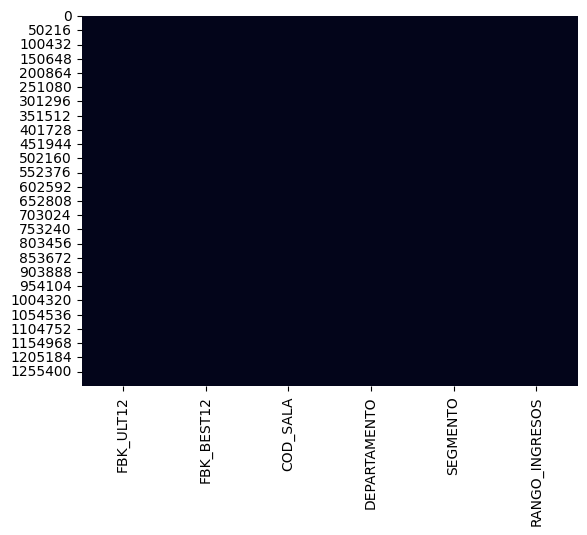

In [62]:
sns.heatmap(df_cat.isnull(), cbar=False)

In [63]:
df.shape[0] == df_cat.shape[0]

True

#### 4. Limpieza y tratamiendo de datos numéricos

In [77]:
# Seleccionar las columnas con datos númericos
df_num = df.select_dtypes(include=['float64', 'int64'])

In [78]:
# Eliminar columnas
df_num = df_num.drop(columns=['IDGRUPO', 'INGRESO_BRUTO', 'INGRESO_NETO_VIGENTE', 'TARGET', 'DIAS_ACT'])
print('Eliminando columnas')

Eliminando columnas


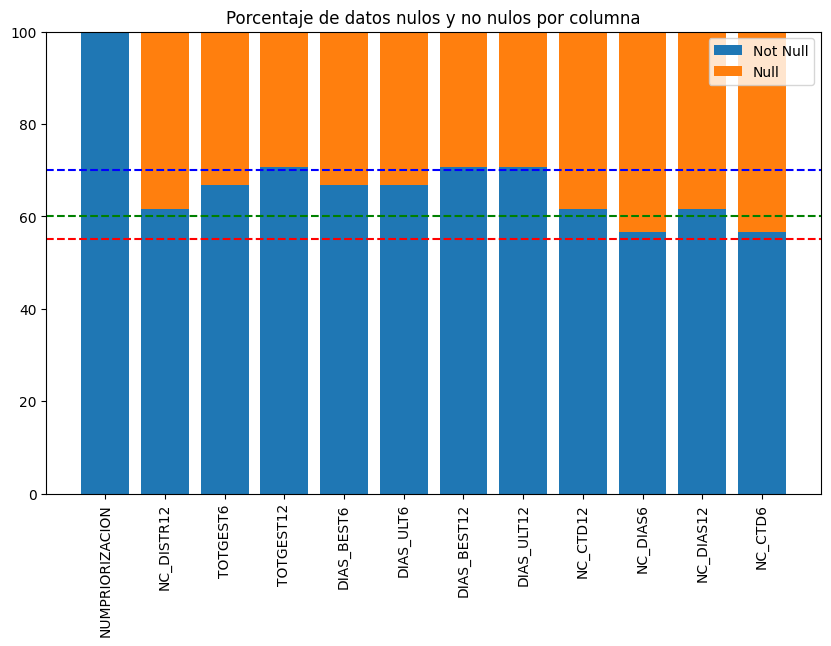

In [79]:
plot_percent_cols(df_num, li=55, lm=60, ls=70)

<Axes: >

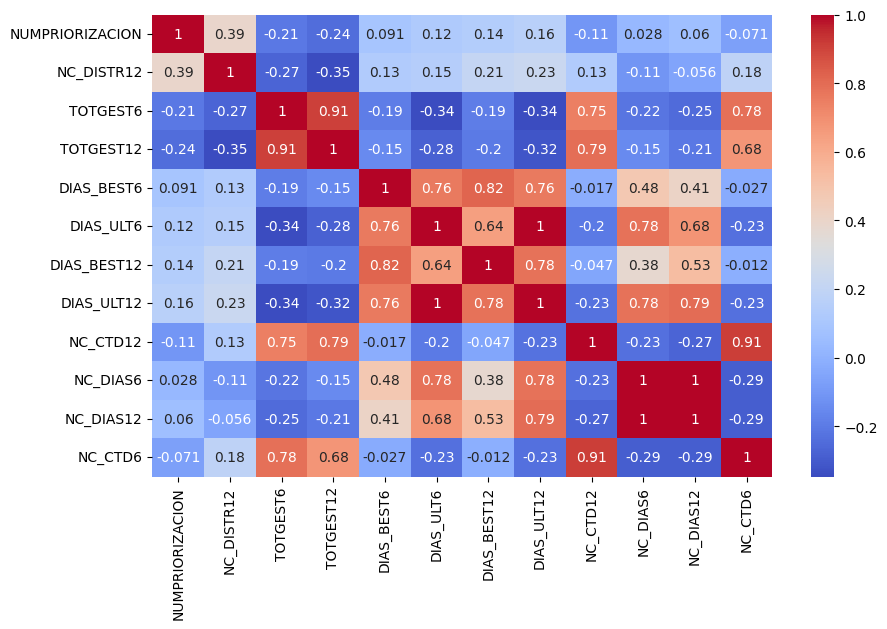

In [80]:
# Graficar la correlación de columnas númericas
plt.figure(figsize=(10, 6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')

In [81]:
# Eliminar columnas con correlación mayor a 0.9
corr = df_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
df_num = df_num.drop(columns=to_drop)
print('Eliminando columnas')

Eliminando columnas


<Axes: >

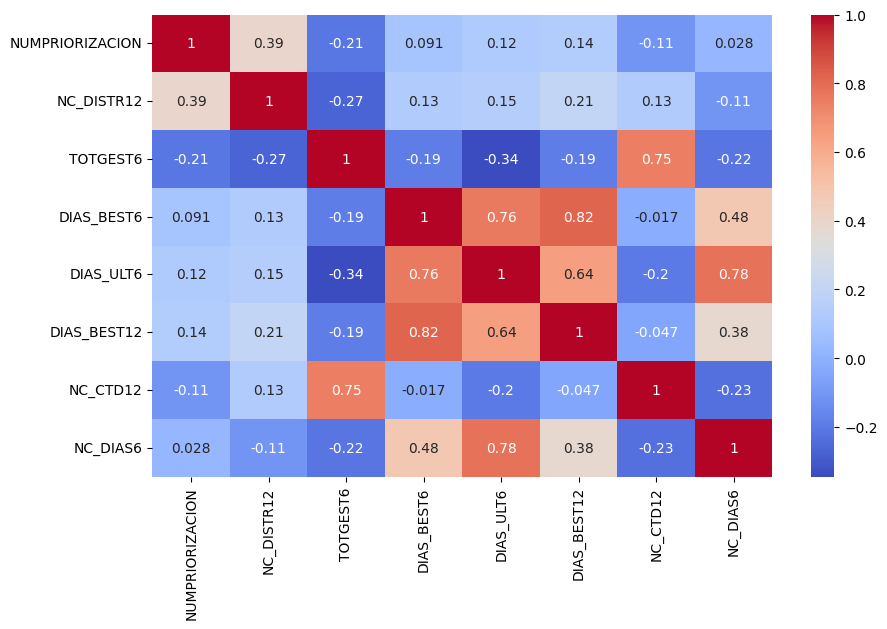

In [82]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')

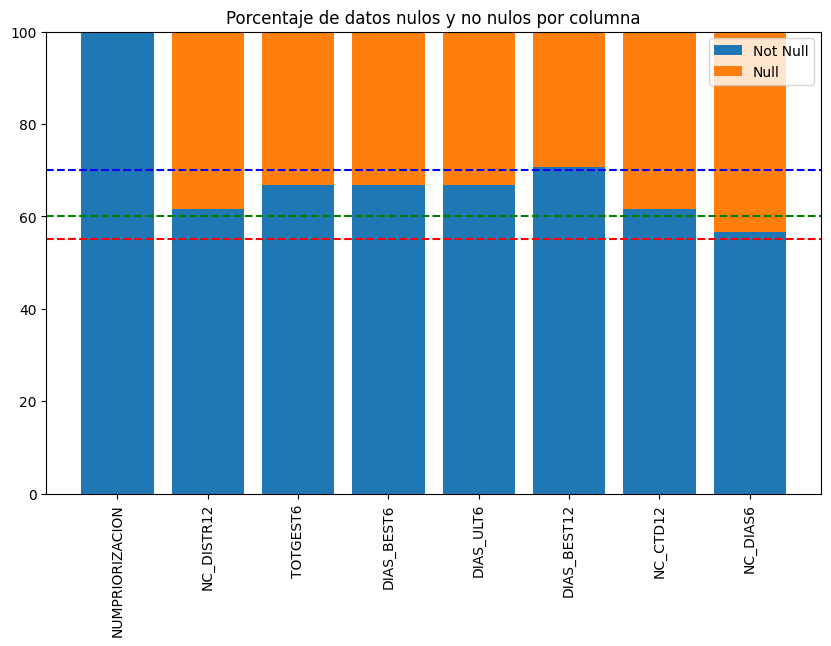

In [83]:
plot_percent_cols(df_num, li=55, lm=60, ls=70)

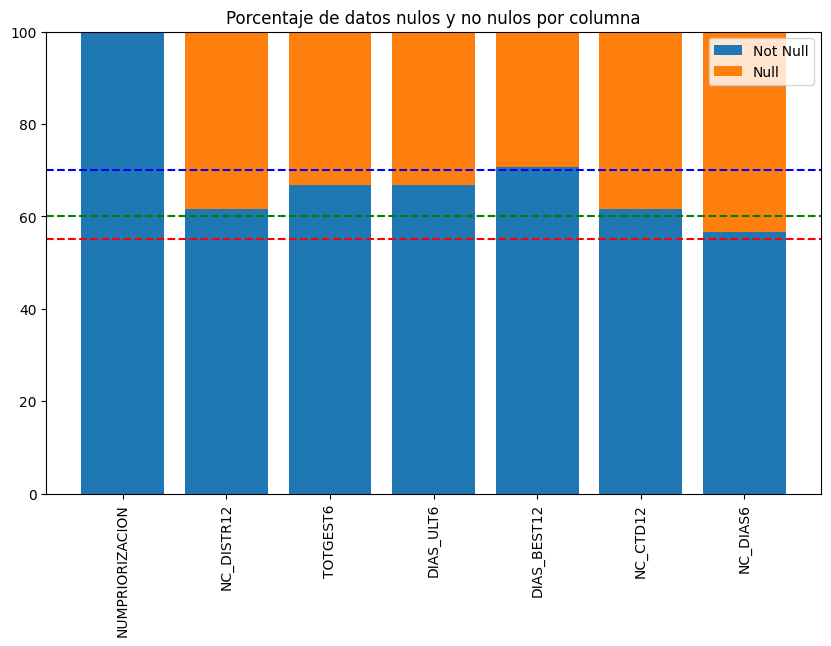

In [84]:
# Eliminar DIAS_BEST6
df_num = df_num.drop(columns=['DIAS_BEST6'])
plot_percent_cols(df_num, li=55, lm=60, ls=70)

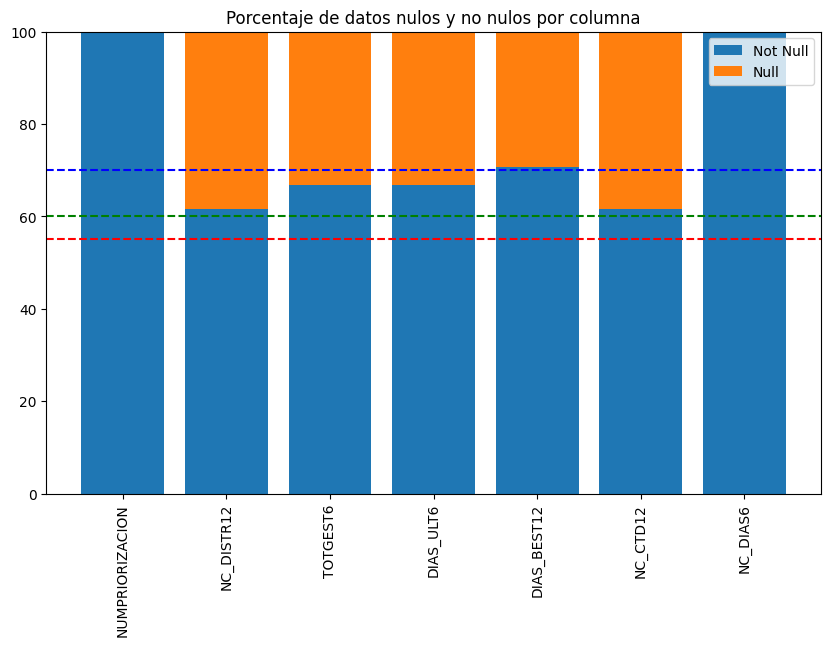

In [85]:
# NC_DIAS6: Imputar la mediana
df_num['NC_DIAS6'] = df_num['NC_DIAS6'].fillna(df_num['NC_DIAS6'].median())
plot_percent_cols(df_num, li=55, lm=60, ls=70)

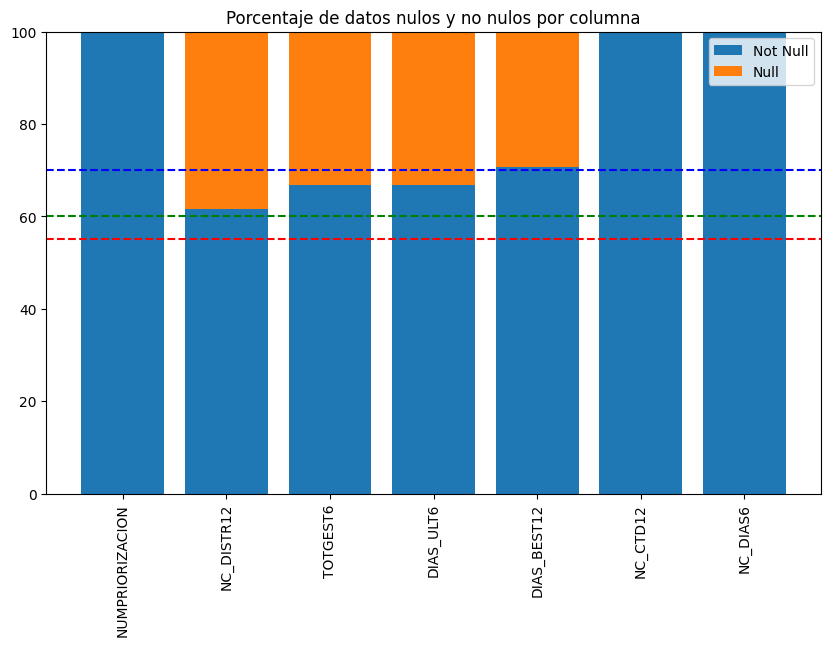

In [86]:
# NC_CTD12: Imputar la mediana
df_num['NC_CTD12'] = df_num['NC_CTD12'].fillna(df_num['NC_CTD12'].median())
plot_percent_cols(df_num, li=55, lm=60, ls=70)

In [87]:
# Inputación multiple
imputer = IterativeImputer(max_iter=10, random_state=0)
df_num['NC_DISTR12'] = imputer.fit_transform(df_num[['NC_DISTR12']])
df_num['TOTGEST6'] = imputer.fit_transform(df_num[['TOTGEST6']])
df_num['DIAS_ULT6'] = imputer.fit_transform(df_num[['DIAS_ULT6']])
df_num['DIAS_BEST12'] = imputer.fit_transform(df_num[['DIAS_BEST12']])

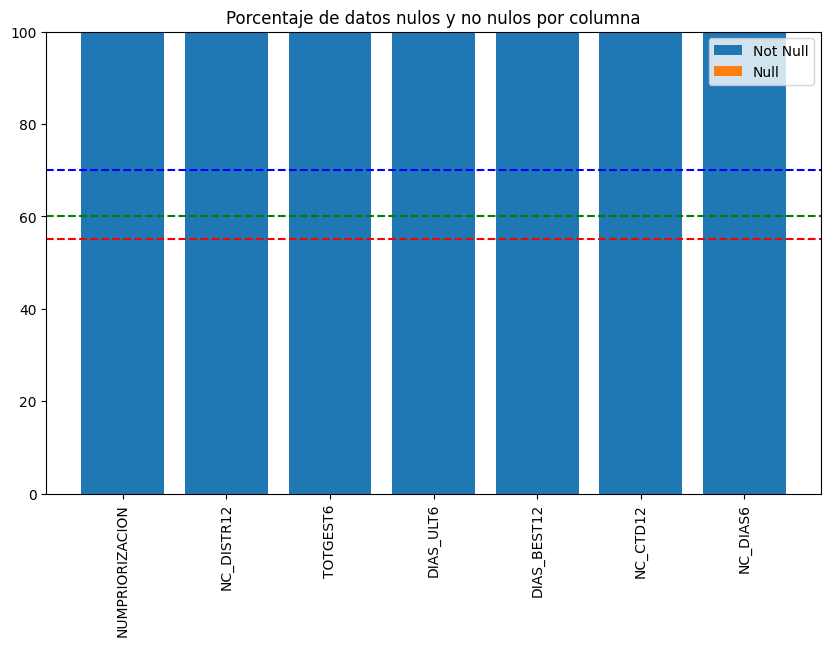

In [88]:
plot_percent_cols(df_num, li=55, lm=60, ls=70)

In [91]:
df.shape[0] == df_num.shape[0]

True

### 5. Unir datos 

In [97]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final['TARGET'] = df['TARGET']
df_final['DF_TYPE'] = df['DF_TYPE']
df_final.to_parquet('./data/2_data_preprocesada.parquet')

,FBK_ULT12,FBK_BEST12,COD_SALA,DEPARTAMENTO,SEGMENTO,RANGO_INGRESOS,NUMPRIORIZACION,NC_DISTR12,TOTGEST6,DIAS_ULT6,DIAS_BEST12,NC_CTD12,NC_DIAS6,TARGET,DF_TYPE
0,TLV,TLV,EC,FUERA DE LIMA,2,Entre S/.4000-10000,1,0.333333,6.000000,8.000000,8.000000,2.0,58.0,1,TRAIN
1,TLV,TLV,PP,LIMA,1BC,Entre S/.4000-10000,1,0.461538,13.000000,9.000000,46.000000,6.0,9.0,1,TRAIN
2,TLV,TLV,PA,LIMA,2,Entre S/.1000-4000,1,0.666667,2.000000,127.000000,223.000000,4.0,127.0,1,TRAIN
3,TLV,TLV,NC,LIMA,2,Entre S/.1000-4000,1,0.587062,4.000000,49.000000,49.000000,4.0,38.0,1,TRAIN
4,TLV,TLV,EC,FUERA DE LIMA,3,Entre S/.4000-10000,1,0.187500,10.000000,27.000000,27.000000,3.0,140.0,1,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305600,SIN DATOS,SIN DATOS,NC,FUERA DE LIMA,5,Entre S/.600-1000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST
1305601,SIN DATOS,SIN DATOS,2DA,FUERA DE LIMA,1BC,Entre S/.4000-10000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST
1305602,SIN DATOS,SIN DATOS,NC,LIMA,3,Sin ingresos,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,1,TEST
1305603,SIN DATOS,SIN DATOS,NC,LIMA,3,Entre S/.1000-4000,2,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST
